In [1]:
import os
import csv
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ------------------------------------------------------
# CONFIGURATION - يمكن تعديله بسهولة
# ------------------------------------------------------
CSV_FILE_NAME = "labels.csv"  # اسم ملف الـ labels
AUGMENTED_DATASET_FOLDER = "augmented_dataset"  # اسم مجلد البيانات الموسعة

# ------------------------------------------------------
# Helper: Load + Resize (To avoid MemoryError)
# ------------------------------------------------------
def load_and_resize(img_path, size=(512, 512)):
    img = Image.open(img_path).convert('RGB')
    img = img.resize(size)
    img_array = np.array(img).astype(np.uint8)
    return img_array.reshape((1,) + img_array.shape)

# ------------------------------------------------------
# Paths - تعديل المسارات لتعمل على Colab
# ------------------------------------------------------
# Fix: Explicitly set the base dataset path based on user's previous input
# Assuming the structure is base_dataset_path/split/class/image.jpg
base_dataset_path = "/content/drive/MyDrive/archive/Quality Dataset"
splits = ["train", "test", "valid"] # Corrected 'val' to 'valid'
classes = ["fresh", "rotten"] # Corrected 'Healthy' to 'fresh'

print("="*60)
print("CHECKING DATASET STRUCTURE (using fixed path)")
print("="*60)

# Check if the base_dataset_path exists
if not os.path.exists(base_dataset_path):
    print(f"ERROR: Base dataset path not found: {base_dataset_path}")
    print("Please ensure 'Quality Dataset' is located under /content/drive/MyDrive/archive")
    raise FileNotFoundError("Dataset base path not found.")
else:
    print(f"Base dataset path found: {base_dataset_path}")

# Verify if expected splits and classes exist under the base path
all_paths_found = True
for split in splits:
    for cls in classes:
        expected_path = os.path.join(base_dataset_path, split, cls)
        if not os.path.exists(expected_path):
            print(f"WARNING: Expected folder not found: {expected_path}")
            all_paths_found = False

if not all_paths_found:
    print("\nERROR: Some expected split/class folders are missing under the base dataset path.")
    print("Please verify your dataset structure matches: base_dataset_path/split/class/")
    raise ValueError("Incorrect dataset structure.")
else:
    print("All expected split/class folders found.")

# Create working directory and set relative paths for generated files
working_dir = "/content/fruit_freshness"
os.makedirs(working_dir, exist_ok=True)
os.chdir(working_dir)

augmented_path = AUGMENTED_DATASET_FOLDER # This will be relative to working_dir
os.makedirs(augmented_path, exist_ok=True)

csv_file = CSV_FILE_NAME # This will be relative to working_dir

print("\n" + "="*60)
print("STARTING DATA AUGMENTATION PIPELINE")
print("="*60)

total_images = 0
with open(csv_file, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["filename", "days_to_rot", "split_name"]) # Added split_name column

    for split in splits:
        for cls in classes:

            class_path = os.path.join(base_dataset_path, split, cls)
            print(f"\nProcessing: {class_path}")

            images = [img for img in os.listdir(class_path)
                     if img.lower().endswith((".jpg", ".jpeg", ".png"))]
            print(f"  Found {len(images)} images")

            if len(images) == 0:
                print(f"  Warning: No images found in {class_path}, skipping.")
                continue

            # Map 'valid' split back to 'val' for internal consistency if needed later or in filenames
            output_split_name = 'val' if split == 'valid' else split

            augmented_class_path = os.path.join(augmented_path, output_split_name, cls)
            os.makedirs(augmented_class_path, exist_ok=True)

            for img_idx, img_name in enumerate(images[:100]):  # Process up to 100 images per class/split for testing
                img_path = os.path.join(class_path, img_name)

                try:
                    img_array = load_and_resize(img_path)[0]  # Remove batch dimension
                    total_images += 1
                except Exception as e:
                    print(f"  Error loading {img_name}: {e}")
                    continue

                # ------------------------------------------------------
                # Fresh Images (formerly Healthy)
                # ------------------------------------------------------
                if cls == "fresh": # Check for 'fresh' class
                    max_days = 7

                    # Save original image
                    base_name = f"{output_split_name}_{cls}_{img_name}"
                    save_path = os.path.join(augmented_class_path, base_name)
                    Image.fromarray(img_array).save(save_path)
                    writer.writerow([os.path.join(output_split_name, cls, base_name), max_days, output_split_name]) # Added split

                    # Manual augmentation (similar to original logic)
                    for i in range(5):  # generate 5 augmented versions
                        new_img = img_array.copy()

                        # Apply rotation
                        angle = np.random.uniform(-20, 20)
                        M = cv2.getRotationMatrix2D((256, 256), angle, 1)
                        new_img = cv2.warpAffine(new_img, M, (512, 512))

                        # Apply translation
                        tx = np.random.uniform(-0.1, 0.1) * 512
                        ty = np.random.uniform(-0.1, 0.1) * 512
                        M = np.float32([[1, 0, tx], [0, 1, ty]])
                        new_img = cv2.warpAffine(new_img, M, (512, 512))

                        # Apply zoom
                        zoom = np.random.uniform(0.9, 1.1)
                        new_img = cv2.resize(new_img, None, fx=zoom, fy=zoom)

                        # Ensure correct size
                        if new_img.shape[0] != 512 or new_img.shape[1] != 512:
                            new_img = cv2.resize(new_img, (512, 512))

                        # Horizontal flip (50% chance)
                        if np.random.random() > 0.5:
                            new_img = cv2.flip(new_img, 1)

                        # ------------------------------------------------------
                        # Create mask (HSV range for fruit)
                        # ------------------------------------------------------
                        hsv = cv2.cvtColor(new_img, cv2.COLOR_RGB2HSV)
                        lower = np.array([0, 50, 50])
                        upper = np.array([30, 255, 255])
                        mask = cv2.inRange(hsv, lower, upper)

                        # ------------------------------------------------------
                        # Darkening simulation
                        # ------------------------------------------------------
                        # NOTE: 'i' here is the augmentation index, not img_idx
                        darkening_factor = 1 - 0.07 * (i + 1)
                        new_img = (new_img * darkening_factor).astype(np.uint8)

                        # ------------------------------------------------------
                        # Add small rotten spots only if mask is NOT empty
                        # ------------------------------------------------------
                        ys, xs = np.where(mask > 0)

                        if len(xs) > 0:
                            for _ in range(3):
                                idx_rand = np.random.randint(0, len(xs))
                                x, y = xs[idx_rand], ys[idx_rand]
                                radius = np.random.randint(3, 7)
                                color = (
                                    np.random.randint(30, 70),
                                    np.random.randint(30, 70),
                                    np.random.randint(30, 70)
                                )
                                cv2.circle(new_img, (x, y), radius, color, -1)

                        # ------------------------------------------------------
                        # Blur only inside fruit area
                        # ------------------------------------------------------
                        blurred = cv2.GaussianBlur(new_img, (3, 3), 0)
                        new_img = np.where(mask[:, :, None] > 0, blurred, new_img)

                        # ------------------------------------------------------
                        # Add noise only inside fruit
                        # ------------------------------------------------------
                        if len(xs) > 0:
                            noise = np.random.normal(0, 5, new_img.shape).astype(np.uint8)
                            new_img = np.where(mask[:, :, None] > 0, cv2.add(new_img, noise), new_img)

                        # ------------------------------------------------------
                        # Save augmented image
                        # ------------------------------------------------------
                        save_name_aug = f"{output_split_name}_{cls}_{img_name.split('.')[0]}_aug{i+1}.jpg"
                        save_path_aug = os.path.join(augmented_class_path, save_name_aug)
                        Image.fromarray(new_img).save(save_path_aug)

                        writer.writerow([os.path.join(output_split_name, cls, save_name_aug), max_days - (i + 1), output_split_name]) # Added split

                # ------------------------------------------------------
                # Rotten Images
                # ------------------------------------------------------
                else:
                    save_name = f"{output_split_name}_{cls}_{img_name}"
                    save_path = os.path.join(augmented_class_path, save_name)
                    Image.fromarray(img_array).save(save_path)
                    writer.writerow([os.path.join(output_split_name, cls, save_name), 0, output_split_name]) # Added split

                # طباعة التقدم
                if (img_idx + 1) % 10 == 0:
                    print(f"  Processed {img_idx + 1}/{len(images)} images")

print(f"\nTotal images processed: {total_images}")
print("Data augmentation pipeline completed!")

# ------------------------------------------------------
# VISUALIZATION AND DATA ANALYSIS SECTION
# ------------------------------------------------------
print("\n" + "="*60)
print("STARTING DATA VISUALIZATION AND ANALYSIS")
print("="*60)

# استخدام مسارات نسبية - سيتم تعديلها تلقائياً
csv_file_analysis = csv_file  # نفس ملف labels
dataset_path_analysis = augmented_path  # مجلد البيانات الموسعة

# ------------------------------------------------------
# Load CSV
# ------------------------------------------------------
if not os.path.exists(csv_file_analysis):
    print(f"ERROR: CSV file not found: {csv_file_analysis}")
    raise FileNotFoundError(f"CSV file not found: {csv_file_analysis}")

df_analysis = pd.read_csv(csv_file_analysis)
print(f"\nCSV loaded successfully! Shape: {df_analysis.shape}")
print("First 5 rows of CSV:")
print(df_analysis.head())

# تحقق إذا كان DataFrame فارغاً
if len(df_analysis) == 0:
    print("\nWARNING: CSV file is empty! Cannot perform visualization and analysis.")
else:
    # ------------------------------------------------------
    # 1. Distribution of Days to Rot
    # ------------------------------------------------------
    try:
        plt.figure(figsize=(8,5))
        unique_bins = len(df_analysis['days_to_rot'].unique())
        if unique_bins > 0:
            sns.histplot(data=df_analysis, x="days_to_rot", bins=min(20, unique_bins), kde=False)
            plt.title("Distribution of Days to Rot per Image")
            plt.xlabel("Days to Rot")
            plt.ylabel("Number of Images")
            plt.savefig('days_distribution.png')
            plt.close()
            print("Created days_distribution.png")
        else:
            print("Skipping histogram: No valid days_to_rot values")
    except Exception as e:
        print(f"Error creating histogram: {e}")

    # ------------------------------------------------------
    # 2. HSV analysis: Hue, Saturation, Value
    # ------------------------------------------------------
    hues, saturations, values = [], [], []

    # For speed, process first 50 images or all if less
    sample_size = min(50, len(df_analysis))
    sample = df_analysis.head(sample_size)

    print(f"\nProcessing HSV analysis for {sample_size} images...")

    for idx, row in sample.iterrows():
        img_path = os.path.join(dataset_path_analysis, row['filename'])
        if not os.path.exists(img_path):
            print(f"  Missing image: {img_path}")
            continue

        img = cv2.imread(img_path)
        if img is None:
            print(f"  Could not read image: {img_path}")
            continue

        try:
            hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            h, s, v = cv2.split(hsv)
            hues.append(np.mean(h))
            saturations.append(np.mean(s))
            values.append(np.mean(v))
        except Exception as e:
            print(f"  Error processing image {row['filename']}: {e}")

    if hues:  # إذا كانت هناك بيانات
        color_df = pd.DataFrame({
            "Hue": hues,
            "Saturation": saturations,
            "Value": values
        })

        # Histograms
        color_df.hist(figsize=(12,4), bins=20)
        plt.suptitle(f"HSV Distribution (Sample of {len(hues)} Images)")
        plt.tight_layout()
        plt.savefig('hsv_distribution.png')
        plt.close()
        print("Created hsv_distribution.png")

        # Boxplots
        plt.figure(figsize=(12,4))
        sns.boxplot(data=color_df)
        plt.title("HSV Boxplots")
        plt.savefig('hsv_boxplots.png')
        plt.close()
        print("Created hsv_boxplots.png")
    else:
        print("Skipping HSV analysis: No valid images found")

    # ------------------------------------------------------
    # 4. Fresh vs Rotten comparison
    # ------------------------------------------------------
    df_analysis['label'] = df_analysis['days_to_rot'].apply(lambda x: 'Rotten' if x==0 else 'Fresh')

    plt.figure(figsize=(8,5))
    sns.countplot(x='label', data=df_analysis)
    plt.title("Number of Fresh vs Rotten Images")
    plt.savefig('fresh_vs_rotten_count.png')
    plt.close()
    print("Created fresh_vs_rotten_count.png")

    # ------------------------------------------------------
    # 5. Detect invalid or missing images
    # ------------------------------------------------------
    invalid_images = [
        row['filename'] for idx,row in df_analysis.iterrows()
        if not os.path.exists(os.path.join(dataset_path_analysis, row['filename']))
    ]

    if invalid_images:
        print(f"\nInvalid or missing images ({len(invalid_images)}):")
        for img in invalid_images[:5]:  # عرض أول 5 فقط
            print(f"  - {img}")
        if len(invalid_images) > 5:
            print(f"  ... and {len(invalid_images)-5} more")
    else:
        print("\nAll image paths are valid!")

print("\n" + "="*60)
print("DATA VISUALIZATION AND ANALYSIS COMPLETED")
print("="*60)

# ------------------------------------------------------
# ENHANCED MODEL DESIGN & TRAINING - COMPLETE VERSION
# ------------------------------------------------------
print("\n" + "="*60)
print("STARTING ENHANCED MODEL PIPELINE")
print("="*60)

# ------------------------------------------------------
# 1. Load and Prepare Data
# ------------------------------------------------------
# Use the df_analysis generated from augmentation for training
if len(df_analysis) == 0:
    print("ERROR: No data available for training after augmentation!")
    raise ValueError("Cannot proceed with training: No images found after augmentation.")

df = df_analysis.copy()
df['filename'] = df['filename'].apply(lambda x: os.path.join(augmented_path, x))
print(f"Using augmented dataset with {len(df)} images")

# Remove missing files (should not be any if augmentation created them)
df['file_exists'] = df['filename'].apply(os.path.exists)
missing_count = len(df[~df['file_exists']])
if missing_count > 0:
    print(f"Warning: {missing_count} files are missing in augmented dataset. Removing them.")
    df = df[df['file_exists']]
    df = df.drop(columns=['file_exists'])

# Split data using the new 'split_name' column
train_df = df[df['split_name'] == "train"]
val_df = df[df['split_name'] == "val"]
test_df = df[df['split_name'] == "test"]

# If no samples are found in any split, raise an error
if len(train_df) == 0 or len(val_df) == 0 or len(test_df) == 0:
    print("\nERROR: One or more data splits (train, val, test) are empty.")
    print("This indicates an issue with data loading or the dataset structure.")
    raise ValueError("Empty data splits detected, cannot proceed with training.")

print(f"\n   Data Summary:")
print(f"   Train: {len(train_df)} samples")
print(f"   Val: {len(val_df)} samples")
print(f"   Test: {len(test_df)} samples")
print(f"   Total: {len(df)} samples")

# ------------------------------------------------------
# 2. Custom Dataset Class
# ------------------------------------------------------
class FruitFreshnessDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.loc[idx, 'filename']
        label = self.dataframe.loc[idx, 'days_to_rot']

        # Load image
        try:
            img = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # استخدام صورة بديلة
            img = Image.new('RGB', (224, 224), color='white')
            label = 0

        # Apply transforms
        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.float32)

# ------------------------------------------------------
# 3. Enhanced Transforms
# ------------------------------------------------------
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = FruitFreshnessDataset(train_df, transform=train_transform)
val_dataset = FruitFreshnessDataset(val_df, transform=val_transform)
test_dataset = FruitFreshnessDataset(test_df, transform=val_transform)

# Create data loaders
batch_size = 32  # Fixed batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

print(f"\nData loaders created successfully!")
print(f"Batch size: {batch_size}")

# ------------------------------------------------------
# 4. Build Enhanced Model
# ------------------------------------------------------
class EnhancedResNet50(nn.Module):
    def __init__(self):
        super(EnhancedResNet50, self).__init__()
        # Load pre-trained ResNet50
        self.base_model = models.resnet50(pretrained=True)

        # Freeze all layers initially
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Replace the final layer with our regression head
        num_features = self.base_model.fc.in_features

        # Enhanced Regression Head
        self.base_model.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.base_model(x)

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = EnhancedResNet50().to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.base_model.fc.parameters(), lr=1e-4)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-7)

print("Enhanced model architecture created!")

# ------------------------------------------------------
# 5. Training Function
# ------------------------------------------------------
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_mae = 0.0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        # Calculate MAE
        mae = torch.mean(torch.abs(outputs - targets))

        running_loss += loss.item() * inputs.size(0)
        running_mae += mae.item() * inputs.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_mae = running_mae / len(loader.dataset)

    return epoch_loss, epoch_mae

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_mae = 0.0

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)

            # Calculate MAE
            mae = torch.mean(torch.abs(outputs - targets))

            running_loss += loss.item() * inputs.size(0)
            running_mae += mae.item() * inputs.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_mae = running_mae / len(loader.dataset)

    return epoch_loss, epoch_mae

# ------------------------------------------------------
# 6. Enhanced Training
# ------------------------------------------------------
print("\nStarting enhanced training...")

best_val_loss = float('inf')
patience = 7
patience_counter = 0
history = {'train_loss': [], 'train_mae': [], 'val_loss': [], 'val_mae': []}

num_epochs = 50  # Increased number of epochs
for epoch in range(num_epochs):
    # Train
    train_loss, train_mae = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_mae = validate_epoch(model, val_loader, criterion, device)

    # Update learning rate
    scheduler.step(val_loss)

    # Save history
    history['train_loss'].append(train_loss)
    history['train_mae'].append(train_mae)
    history['val_loss'].append(val_loss)
    history['val_mae'].append(val_mae)

    print(f'Epoch {epoch+1:02d}/{num_epochs}: '
          f'Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f} | '
          f'Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}')

    # Early stopping and model checkpointing
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_mae': val_mae,
        }, 'best_fruit_freshness_model.pth')
        print(f'   Model saved! (Improved validation loss: {val_loss:.4f})')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break

# Load best model
if os.path.exists('best_fruit_freshness_model.pth'):
    checkpoint = torch.load('best_fruit_freshness_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
else:
    print("WARNING: No best model checkpoint found. Using the last trained model.")

print("Enhanced training completed successfully!")

# ------------------------------------------------------
# 7. Comprehensive Evaluation
# ------------------------------------------------------
def detailed_evaluation(model, loader, device):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            outputs = model(inputs).squeeze().cpu().numpy()

            all_preds.extend(outputs)
            all_targets.extend(targets.numpy())

    y_true = np.array(all_targets)
    y_pred = np.array(all_preds)

    if len(y_true) == 0:
        print("No data for evaluation!")
        return None, None

    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Classification accuracy (consider >3 days as fresh)
    true_classes = (y_true > 3).astype(int)
    pred_classes = (y_pred > 3).astype(int)
    accuracy = np.mean(true_classes == pred_classes) if len(y_true) > 0 else 0

    print("\n" + "="*60)
    print("COMPREHENSIVE EVALUATION RESULTS")
    print("="*60)
    print(f"Mean Absolute Error (MAE): {mae:.3f} days")
    print(f"Mean Squared Error (MSE): {mse:.3f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.3f} days")
    print(f"R² Score: {r2:.3f}")
    print(f"Classification Accuracy: {accuracy:.3f}")
    print("="*60 + "\n")

    # Show sample predictions
    if len(y_true) > 0:
        print("Sample Predictions vs Actual:")
        for i in range(min(5, len(y_true))):
            print(f"   Sample {i+1}: True={y_true[i]:.1f} days, Predicted={y_pred[i]:.1f} days")

    return y_true, y_pred

# Run detailed evaluation
print("Running comprehensive evaluation...")
y_true, y_pred = detailed_evaluation(model, test_loader, device)

# ------------------------------------------------------
# 8. Save Final Model and Results
# ------------------------------------------------------
# Save the final model
torch.save(model.state_dict(), 'final_fruit_freshness_predictor.pth')
print("Final model saved as 'final_fruit_freshness_predictor.pth'")

# Save training history
history_df = pd.DataFrame(history)
history_df.to_csv('training_history.csv', index=False)
print("Training history saved as 'training_history.csv'")

# Save predictions
if y_true is not None and y_pred is not None:
    results_df = pd.DataFrame({
        'true_days': y_true,
        'predicted_days': y_pred
    })
    results_df.to_csv('model_predictions.csv', index=False)
    print("Predictions saved as 'model_predictions.csv'")
else:
    print("No predictions to save")

# ------------------------------------------------------
# 9. Test the trained model on a sample image
# ------------------------------------------------------
print("\n" + "="*60)
print("TESTING MODEL ON SAMPLE IMAGE")
print("="*60)

def test_model_on_sample():
    """Test the trained model on a random sample from test set"""
    if len(test_df) > 0:
        # Select a random sample from test set
        random_idx = np.random.randint(0, len(test_df))
        test_image_path = test_df.iloc[random_idx]['filename']
        true_days = test_df.iloc[random_idx]['days_to_rot']

        # Load the model
        test_model = EnhancedResNet50()
        test_model.load_state_dict(torch.load('best_fruit_freshness_model.pth', map_location='cpu'))
        test_model.eval()

        # Load and preprocess the image
        img = Image.open(test_image_path).convert('RGB')

        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

        img_tensor = transform(img).unsqueeze(0)

        # Make prediction
        with torch.no_grad():
            prediction = test_model(img_tensor).item()

        # Interpret prediction
        predicted_days = max(0, min(7, round(prediction, 1)))

        print(f"\nTest Image: {os.path.basename(test_image_path)}")
        print(f"True days to rot: {true_days}")
        print(f"Predicted days to rot: {predicted_days}")
        print(f"Prediction error: {abs(predicted_days - true_days):.2f} days")

        # Determine status
        if predicted_days <= 0.5:
            status = "Rotten"
        elif predicted_days > 3.5:
            status = "Fresh"
        else:
            status = "Getting Old"

        print(f"Status: {status}")

        # Display the test image
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.title(f"Test Result\nTrue: {true_days} days, Predicted: {predicted_days} days\nStatus: {status}")
        plt.axis('off')
        plt.savefig('sample_prediction_result.png')
        plt.close()

        print("\nSample prediction saved as 'sample_prediction_result.png'")

        return predicted_days, true_days, status
    else:
        print("Test dataset is empty, cannot perform sample prediction!")
        return None, None, None

# Test the model
test_model_on_sample()

print("\n" + "="*60)
print("PIPELINE COMPLETED SUCCESSFULLY!")
print("="*60)
print("\nGenerated Files:")
print("="*60)
print("1. labels.csv - Dataset labels")
print("2. augmented_dataset/ - Augmented images")
print("3. best_fruit_freshness_model.pth - Best model checkpoint")
print("4. final_fruit_freshness_predictor.pth - Final model")
print("5. training_history.csv - Training history")
print("6. model_predictions.csv - Test predictions")
print("7. days_distribution.png - Days distribution plot")
print("8. hsv_distribution.png - HSV distribution")
print("9. hsv_boxplots.png - HSV boxplots")
print("10. fresh_vs_rotten_count.png - Fresh vs rotten count")
print("11. sample_prediction_result.png - Sample prediction result")
print("="*60)

CHECKING DATASET STRUCTURE (using fixed path)
ERROR: Base dataset path not found: /content/drive/MyDrive/archive/Quality Dataset
Please ensure 'Quality Dataset' is located under /content/drive/MyDrive/archive


FileNotFoundError: Dataset base path not found.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DATASET STRUCTURE
train/fresh: 143 images
train/rotten: 142 images
test/fresh: 12 images
test/rotten: 12 images
valid/fresh: 24 images
valid/rotten: 24 images

COLLECTING DATA WITH ORIGINAL SPLITS
Processing train/fresh -> train/Healthy: 143 images
Processing train/rotten -> train/Rotten: 142 images
Processing test/fresh -> test/Healthy: 12 images
Processing test/rotten -> test/Rotten: 12 images
Processing valid/fresh -> val/Healthy: 24 images
Processing valid/rotten -> val/Rotten: 24 images

Total images processed: 643

ANALYZING COLLECTED DATA
DataFrame shape: (643, 4)

First 5 rows:
                                 filename  days_to_rot original_split  \
0       train/Healthy/train_Healthy_0.jpg            7          train   
1  train/Healthy/train_Healthy_0_aug1.jpg            6          train   
2  train/Healthy/train_Healthy_0_aug2.jpg            5     

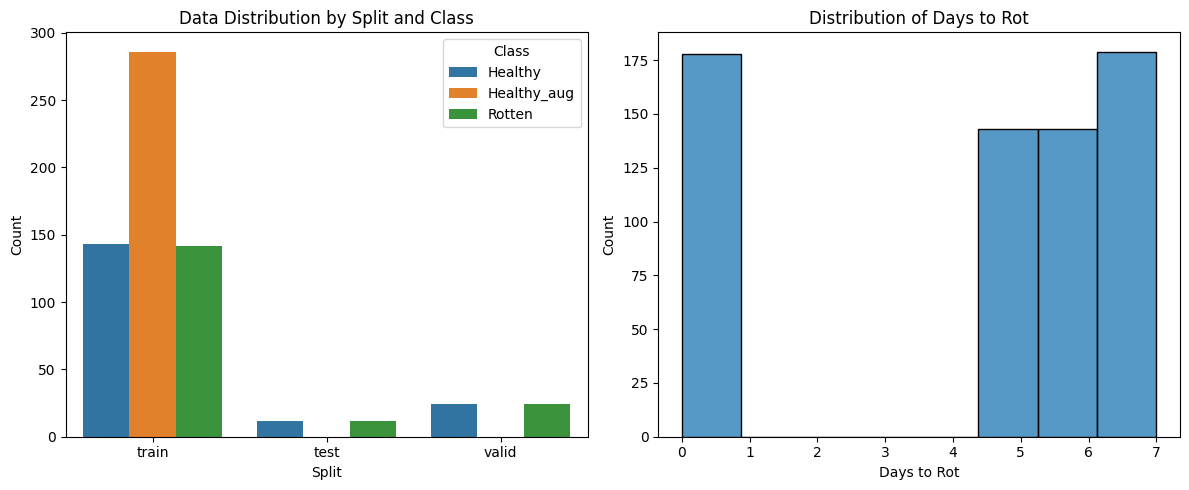

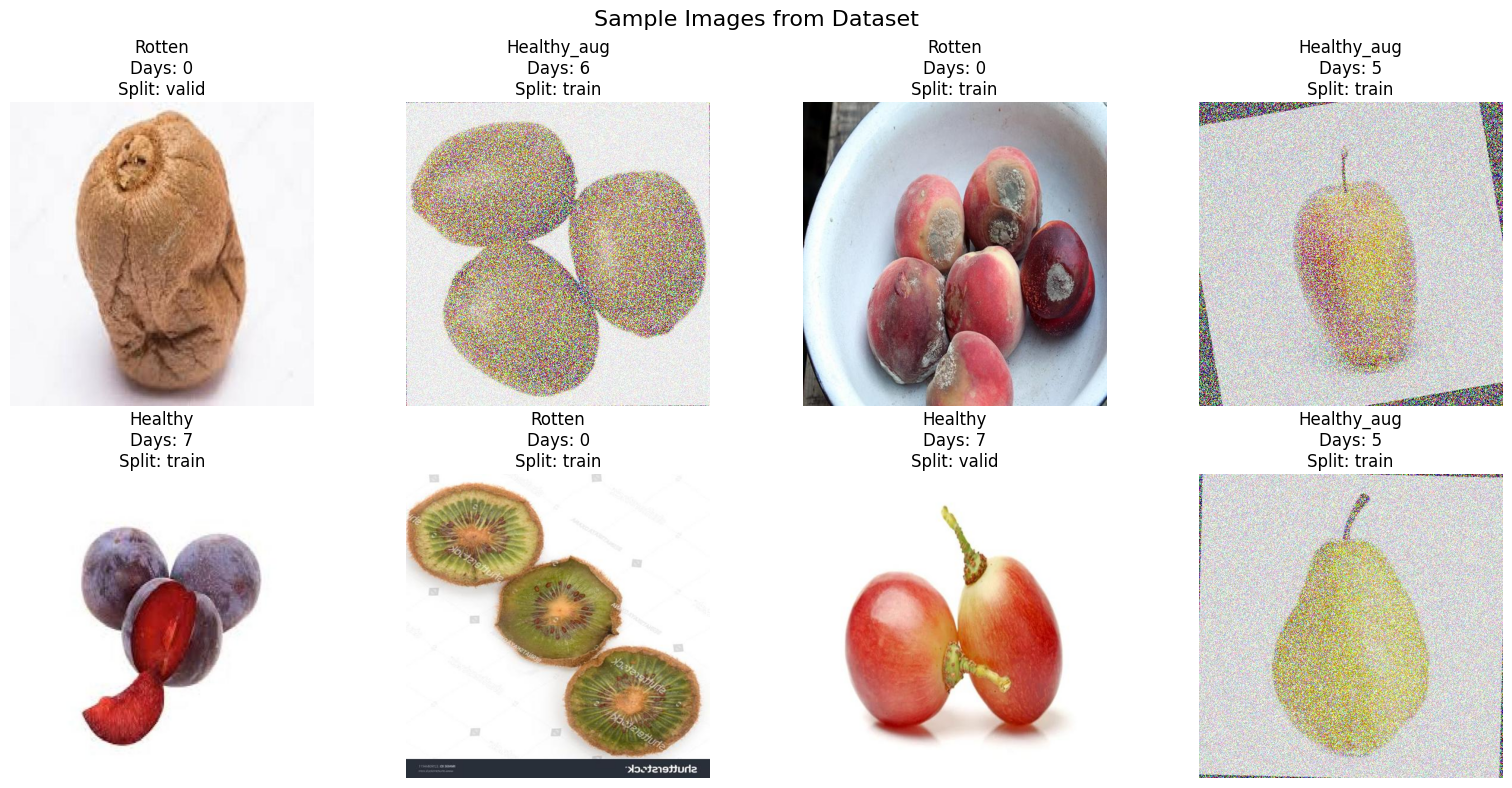


PREPARING DATA FOR TRAINING
Files exist: 643/643

Initial data split:
  Train: 571 samples
  Validation: 48 samples
  Test: 24 samples

Class distribution in training set:
binary_class
1    429
0    142
Name: count, dtype: int64
Fresh: 429 samples
Rotten: 142 samples

Data loaders created with batch size: 32

Using device: cuda
Total parameters: 25,280,707
Trainable parameters: 25,055,363

STARTING TRAINING WITH RESNET50
Epoch 01/25:
  Train - Reg Loss: 10.8500, Cls Loss: 0.3140, Total Loss: 7.6892, Accuracy: 88.27%
  Val   - Reg Loss: 5.9433, Cls Loss: 0.3413, Total Loss: 4.2627, Accuracy: 85.42%
  ✓ Model saved! (Best accuracy: 85.42%)
Epoch 02/25:
  Train - Reg Loss: 1.9643, Cls Loss: 0.0535, Total Loss: 1.3911, Accuracy: 98.95%
  Val   - Reg Loss: 4.1462, Cls Loss: 0.3938, Total Loss: 3.0205, Accuracy: 93.75%
  ✓ Model saved! (Best accuracy: 93.75%)
Epoch 03/25:
  Train - Reg Loss: 1.3433, Cls Loss: 0.0194, Total Loss: 0.9461, Accuracy: 99.47%
  Val   - Reg Loss: 3.3421, Cls Loss:

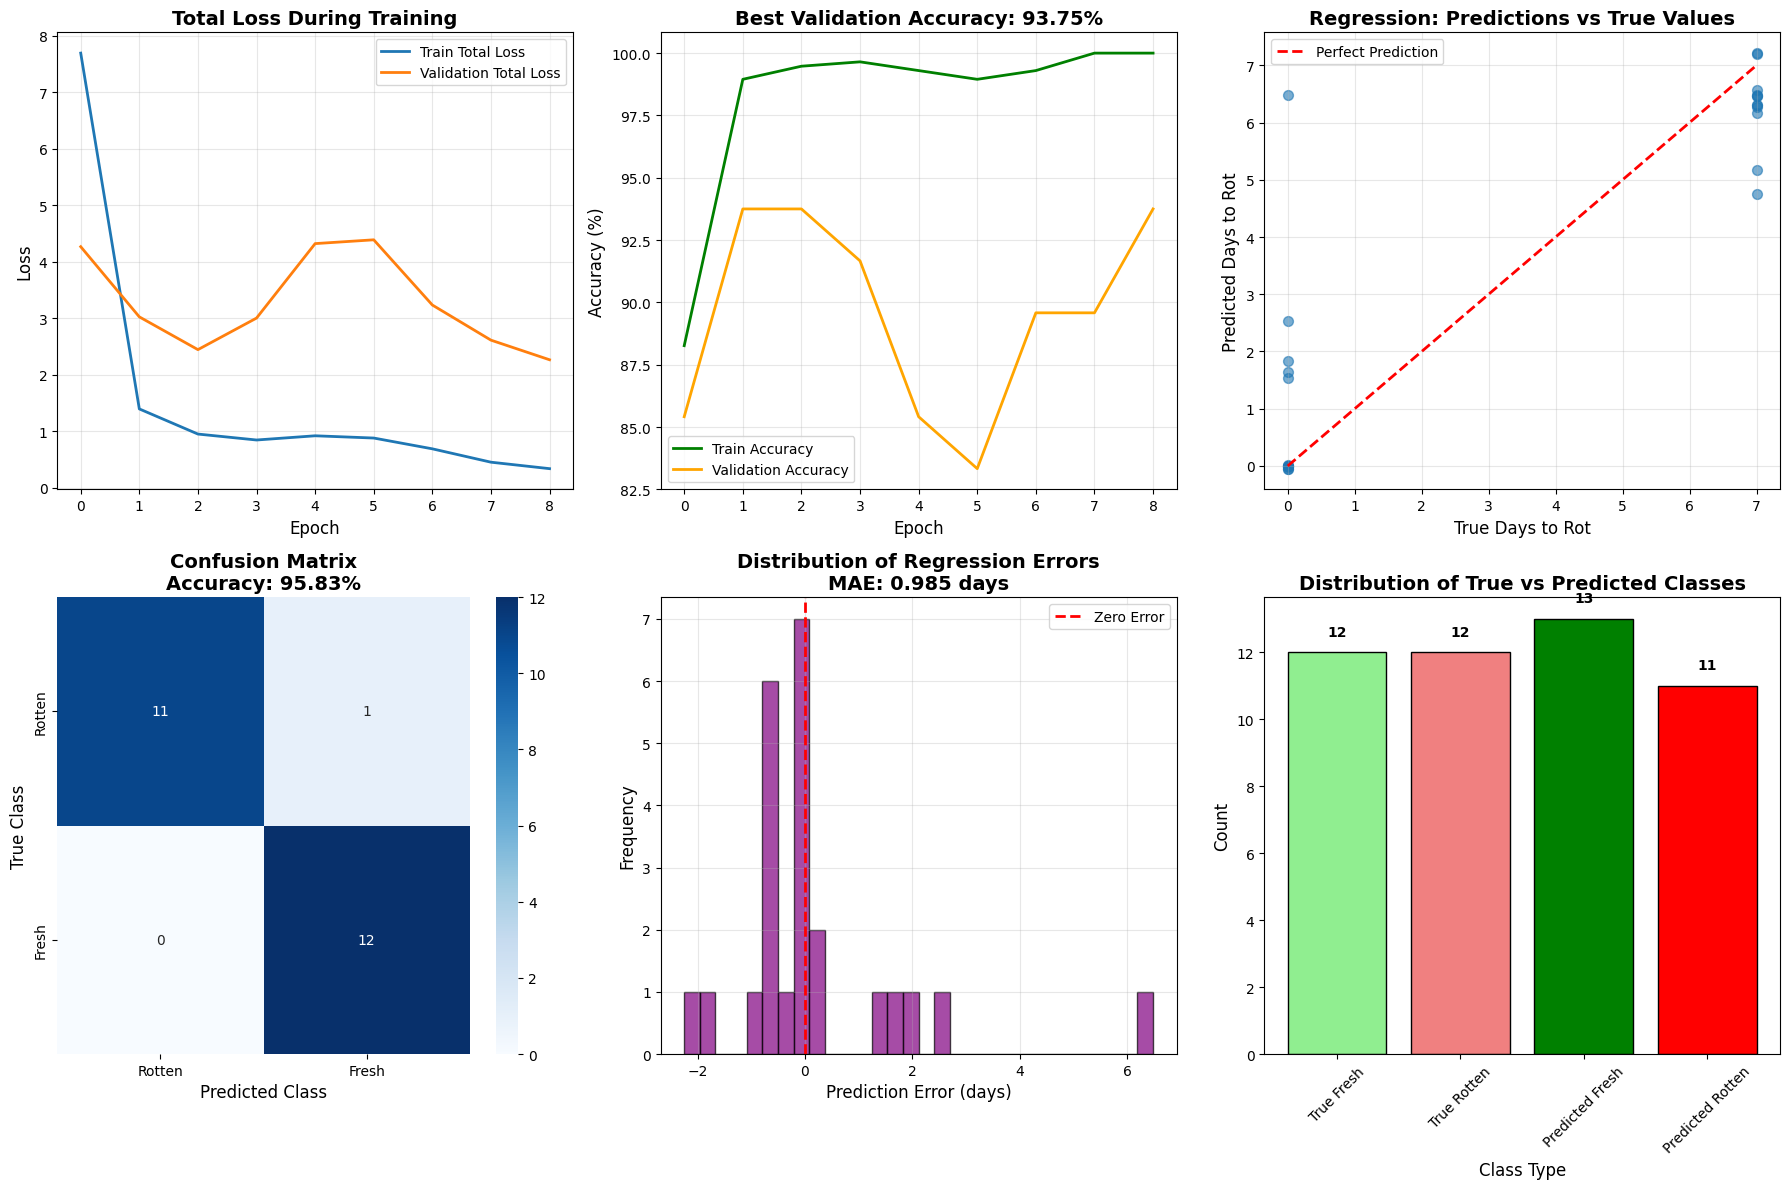


TESTING ON RANDOM SAMPLE IMAGES
Sample 1:
  Image: test_Healthy_8.jpg
  True: Fresh (7 days)
  Predicted: Fresh (6.5 days)
  Confidence: 99.6%
  Regression Error: 0.5 days
  Classification: ✓ CORRECT

Sample 2:
  Image: test_Rotten_4.jpg
  True: Rotten (0 days)
  Predicted: Rotten (0.0 days)
  Confidence: 100.0%
  Regression Error: 0.0 days
  Classification: ✓ CORRECT

Sample 3:
  Image: test_Healthy_0.jpg
  True: Fresh (7 days)
  Predicted: Fresh (6.3 days)
  Confidence: 99.7%
  Regression Error: 0.7 days
  Classification: ✓ CORRECT

Sample 4:
  Image: test_Rotten_6.jpg
  True: Rotten (0 days)
  Predicted: Rotten (2.5 days)
  Confidence: 78.9%
  Regression Error: 2.5 days
  Classification: ✓ CORRECT

Sample 5:
  Image: test_Healthy_11.jpg
  True: Fresh (7 days)
  Predicted: Fresh (6.6 days)
  Confidence: 99.2%
  Regression Error: 0.4 days
  Classification: ✓ CORRECT

Sample 6:
  Image: test_Healthy_9.jpg
  True: Fresh (7 days)
  Predicted: Fresh (7.0 days)
  Confidence: 99.8%
  Regre

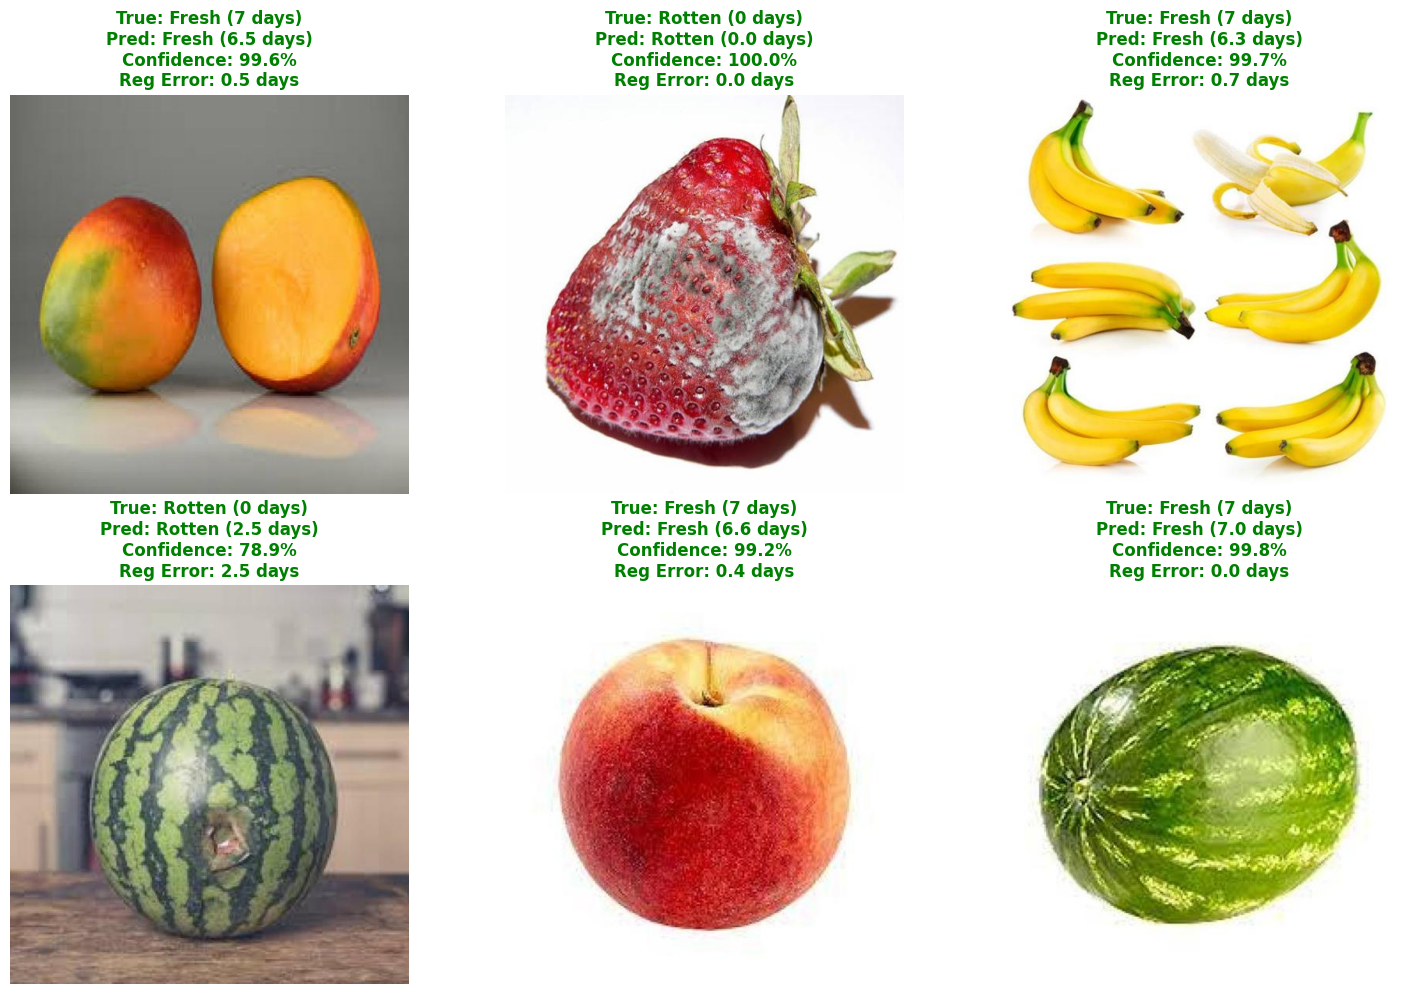


FINAL SUMMARY

MODEL PERFORMANCE SUMMARY:
Dataset Size: 643 total images
Training Set: 571 images
Validation Set: 48 images
Test Set: 24 images

CLASSIFICATION METRICS (%):
  Accuracy:  95.83%
  Precision: 92.31%
  Recall:    100.00%
  F1-Score:  96.00%

REGRESSION METRICS:
  MAE:  0.985 days
  RMSE: 1.691 days
  R²:   0.766

BEST MODEL INFO:
  Epoch: 2
  Validation Accuracy: 93.75%
  Validation Loss: 3.0205

FILES SAVED:
  1. best_fruit_freshness_model_resnet50.pth - Best model
  2. test_predictions_resnet50.csv - Test predictions
  3. training_history_resnet50.csv - Training history
  4. training_results_resnet50.png - Performance plots
  5. sample_predictions_resnet50.png - Sample predictions
  6. data_distribution.png - Data distribution
  7. sample_images.png - Sample images

Working directory: /content/fruit_freshness


In [24]:
import os
import csv
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ------------------------------------------------------
# CONFIGURATION
# ------------------------------------------------------
CSV_FILE_NAME = "labels.csv"
AUGMENTED_DATASET_FOLDER = "augmented_dataset"

# ------------------------------------------------------
# Mount Google Drive
# ------------------------------------------------------
from google.colab import drive
drive.mount('/content/drive')

# ------------------------------------------------------
# Helper: Load + Resize
# ------------------------------------------------------
def load_and_resize(img_path, size=(512, 512)):
    img = Image.open(img_path).convert('RGB')
    img = img.resize(size)
    img_array = np.array(img).astype(np.uint8)
    return img_array.reshape((1,) + img_array.shape)

# ------------------------------------------------------
# Paths
# ------------------------------------------------------
dataset_path = "/content/drive/MyDrive/archive/Quality Dataset"

print("="*60)
print("DATASET STRUCTURE")
print("="*60)

# استعراض هيكل dataset
for split in ['train', 'test', 'valid']:
    for cls in ['fresh', 'rotten']:
        path = os.path.join(dataset_path, split, cls)
        if os.path.exists(path):
            images = [f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            print(f"{split}/{cls}: {len(images)} images")

# إنشاء مجلد العمل
working_dir = "/content/fruit_freshness"
os.makedirs(working_dir, exist_ok=True)
os.chdir(working_dir)

augmented_path = os.path.join(working_dir, AUGMENTED_DATASET_FOLDER)
os.makedirs(augmented_path, exist_ok=True)

# ------------------------------------------------------
# جمع البيانات مع الحفاظ على تقسيم الأصل
# ------------------------------------------------------
print("\n" + "="*60)
print("COLLECTING DATA WITH ORIGINAL SPLITS")
print("="*60)

csv_file = os.path.join(working_dir, CSV_FILE_NAME)

with open(csv_file, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["filename", "days_to_rot", "original_split", "class"])

    total_images = 0
    splits_map = {'valid': 'val'}  # تحويل valid إلى val

    for original_split in ['train', 'test', 'valid']:
        for original_cls in ['fresh', 'rotten']:
            source_dir = os.path.join(dataset_path, original_split, original_cls)

            if not os.path.exists(source_dir):
                continue

            images = [f for f in os.listdir(source_dir)
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

            if not images:
                continue

            # تحويل التسميات
            target_split = splits_map.get(original_split, original_split)
            target_cls = "Healthy" if original_cls == "fresh" else "Rotten"

            # إنشاء مجلد الهدف
            target_dir = os.path.join(augmented_path, target_split, target_cls)
            os.makedirs(target_dir, exist_ok=True)

            print(f"Processing {original_split}/{original_cls} -> {target_split}/{target_cls}: {len(images)} images")

            for idx, img_name in enumerate(images):
                try:
                    img_path = os.path.join(source_dir, img_name)
                    img_array = load_and_resize(img_path)[0]

                    # حفظ الصورة
                    new_name = f"{target_split}_{target_cls}_{idx}.jpg"
                    save_path = os.path.join(target_dir, new_name)
                    Image.fromarray(img_array).save(save_path)

                    # تحديد عدد الأيام
                    days = 7 if target_cls == "Healthy" else 0

                    writer.writerow([
                        os.path.join(target_split, target_cls, new_name),
                        days,
                        original_split,
                        target_cls
                    ])
                    total_images += 1

                    # إنشاء نسخ موسعة للصور الصحية فقط في مجموعة التدريب
                    if target_cls == "Healthy" and target_split == "train":
                        for aug_idx in range(2):  # نسختان موسعتان فقط
                            new_img = img_array.copy()

                            # تحويلات بسيطة
                            if np.random.random() > 0.5:
                                new_img = cv2.flip(new_img, 1)

                            # تدوير بسيط
                            angle = np.random.uniform(-10, 10)
                            M = cv2.getRotationMatrix2D((256, 256), angle, 1)
                            new_img = cv2.warpAffine(new_img, M, (512, 512))

                            # تقليل السطوع
                            factor = 1 - 0.15 * (aug_idx + 1)
                            new_img = (new_img * factor).astype(np.uint8)

                            # إضافة بعض الضوضاء
                            noise = np.random.normal(0, 8, new_img.shape).astype(np.uint8)
                            new_img = cv2.add(new_img, noise)

                            # حفظ النسخة الموسعة
                            aug_name = f"{target_split}_{target_cls}_{idx}_aug{aug_idx+1}.jpg"
                            aug_path = os.path.join(target_dir, aug_name)
                            Image.fromarray(new_img).save(aug_path)

                            writer.writerow([
                                os.path.join(target_split, target_cls, aug_name),
                                max(0, days - (aug_idx + 1)),
                                original_split,
                                target_cls + "_aug"
                            ])
                            total_images += 1

                except Exception as e:
                    print(f"Error processing {img_name}: {e}")

print(f"\nTotal images processed: {total_images}")

# ------------------------------------------------------
# قراءة وتحليل البيانات
# ------------------------------------------------------
print("\n" + "="*60)
print("ANALYZING COLLECTED DATA")
print("="*60)

df = pd.read_csv(csv_file)
print(f"DataFrame shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())

print("\nDistribution by split:")
print(df['original_split'].value_counts())

print("\nDistribution by class:")
print(df['class'].value_counts())

print("\nDistribution by days_to_rot:")
print(df['days_to_rot'].value_counts().sort_index())

# ------------------------------------------------------
# إنشاء تصورات
# ------------------------------------------------------
print("\n" + "="*60)
print("CREATING VISUALIZATIONS")
print("="*60)

# 1. توزيع البيانات حسب المجموعة
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(data=df, x='original_split', hue='class')
plt.title('Data Distribution by Split and Class')
plt.xlabel('Split')
plt.ylabel('Count')
plt.legend(title='Class')

plt.subplot(1, 2, 2)
sns.histplot(data=df, x='days_to_rot', bins=8)
plt.title('Distribution of Days to Rot')
plt.xlabel('Days to Rot')
plt.ylabel('Count')

plt.tight_layout()
plt.savefig('data_distribution.png')
plt.show()

# 2. عرض عينة من الصور
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
sample_df = df.sample(8, random_state=42)

for idx, (_, row) in enumerate(sample_df.iterrows()):
    ax = axes[idx // 4, idx % 4]

    img_path = os.path.join(augmented_path, row['filename'])
    if os.path.exists(img_path):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(f"{row['class']}\nDays: {row['days_to_rot']}\nSplit: {row['original_split']}")
        ax.axis('off')
    else:
        ax.text(0.5, 0.5, f"Missing: {row['filename']}",
               ha='center', va='center', transform=ax.transAxes)
        ax.axis('off')

plt.suptitle('Sample Images from Dataset', fontsize=16)
plt.tight_layout()
plt.savefig('sample_images.png')
plt.show()

# ------------------------------------------------------
# إعداد البيانات للتدريب
# ------------------------------------------------------
print("\n" + "="*60)
print("PREPARING DATA FOR TRAINING")
print("="*60)

# إضافة عمود split
df['split'] = df['original_split'].map({'train': 'train', 'test': 'test', 'valid': 'val'})
df['full_path'] = df['filename'].apply(lambda x: os.path.join(augmented_path, x))

# التحقق من وجود الملفات
df['file_exists'] = df['full_path'].apply(os.path.exists)
print(f"Files exist: {df['file_exists'].sum()}/{len(df)}")

# استخدام فقط الملفات الموجودة
df = df[df['file_exists']].drop(columns=['file_exists'])

# إضافة تصنيف ثنائي (Fresh=1, Rotten=0)
df['binary_class'] = df['days_to_rot'].apply(lambda x: 1 if x > 3 else 0)

# تقسيم البيانات
train_df = df[df['split'] == 'train']
val_df = df[df['split'] == 'val']
test_df = df[df['split'] == 'test']

print(f"\nInitial data split:")
print(f"  Train: {len(train_df)} samples")
print(f"  Validation: {len(val_df)} samples")
print(f"  Test: {len(test_df)} samples")

# إذا كانت مجموعات val أو test فارغة، نقسم train
if len(val_df) == 0 or len(test_df) == 0:
    print("\nSplitting train data to create val/test sets...")
    train_df, temp_df = train_test_split(train_df, test_size=0.3, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

    print(f"  After splitting:")
    print(f"  Train: {len(train_df)} samples")
    print(f"  Validation: {len(val_df)} samples")
    print(f"  Test: {len(test_df)} samples")

print(f"\nClass distribution in training set:")
print(train_df['binary_class'].value_counts())
print(f"Fresh: {(train_df['binary_class'] == 1).sum()} samples")
print(f"Rotten: {(train_df['binary_class'] == 0).sum()} samples")

# ------------------------------------------------------
# Dataset Class
# ------------------------------------------------------
class FruitFreshnessDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.loc[idx, 'full_path']
        label = self.dataframe.loc[idx, 'days_to_rot']
        binary_label = self.dataframe.loc[idx, 'binary_class']

        try:
            img = Image.open(img_path).convert('RGB')
        except:
            # إنشاء صورة بديلة إذا فشل التحميل
            img = Image.new('RGB', (224, 224), color='white')
            label = 0
            binary_label = 0

        if self.transform:
            img = self.transform(img)

        # إرجاع كل من التصنيف الثنائي والانحدار
        return img, torch.tensor(label, dtype=torch.float32), torch.tensor(binary_label, dtype=torch.long)

# ------------------------------------------------------
# Data Transforms
# ------------------------------------------------------
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# إنشاء Datasets
train_dataset = FruitFreshnessDataset(train_df, transform=train_transform)
val_dataset = FruitFreshnessDataset(val_df, transform=val_transform)
test_dataset = FruitFreshnessDataset(test_df, transform=val_transform)

# إنشاء DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print(f"\nData loaders created with batch size: {batch_size}")

# ------------------------------------------------------
# بناء النموذج باستخدام ResNet50
# ------------------------------------------------------
class EnhancedResNet50Model(nn.Module):
    def __init__(self, num_classes=2):
        super(EnhancedResNet50Model, self).__init__()

        # استخدام ResNet50 مسبق التدريب
        self.base_model = models.resnet50(pretrained=True)

        # تجميد جميع الطبقات في البداية
        for param in self.base_model.parameters():
            param.requires_grad = False

        # تعديل الطبقة الأخيرة
        num_features = self.base_model.fc.in_features

        # رأس متعدد المهام: للانحدار والتصنيف
        self.base_model.fc = nn.Identity()  # إزالة الطبقة الأخيرة

        # رأس الانحدار
        self.regression_head = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # إخراج واحد للانحدار
        )

        # رأس التصنيف
        self.classification_head = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)  # إخراج للتصنيف الثنائي
        )

    def forward(self, x):
        features = self.base_model(x)
        regression_output = self.regression_head(features).squeeze()
        classification_output = self.classification_head(features)
        return regression_output, classification_output

    def unfreeze_layers(self, num_layers=10):
        """إلغاء تجميد الطبقات الأخيرة للتدريب الدقيق"""
        # إلغاء تجميد الطبقات الأخيرة
        layers = list(self.base_model.children())[-num_layers:]
        for layer in layers:
            for param in layer.parameters():
                param.requires_grad = True

# ------------------------------------------------------
# إعداد التدريب
# ------------------------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

model = EnhancedResNet50Model().to(device)

# إلغاء تجميد بعض الطبقات للتدريب الدقيق
model.unfreeze_layers(5)

# دالة الخسارة المركبة
regression_criterion = nn.MSELoss()
classification_criterion = nn.CrossEntropyLoss()

# المحددات
regression_params = list(model.regression_head.parameters()) + list(model.classification_head.parameters())
frozen_params = [p for p in model.base_model.parameters() if p.requires_grad]
optimizer = optim.Adam([
    {'params': regression_params, 'lr': 0.001},
    {'params': frozen_params, 'lr': 0.0001}
], weight_decay=1e-4)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# ------------------------------------------------------
# دوال التدريب والتقييم
# ------------------------------------------------------
def train_epoch(model, loader, regression_criterion, classification_criterion, optimizer, device, alpha=0.7):
    """epoch تدريب واحد"""
    model.train()
    running_reg_loss = 0.0
    running_cls_loss = 0.0
    running_total_loss = 0.0
    correct = 0
    total = 0

    for inputs, reg_targets, cls_targets in loader:
        inputs, reg_targets, cls_targets = inputs.to(device), reg_targets.to(device), cls_targets.to(device)

        optimizer.zero_grad()

        # التنبؤات
        reg_outputs, cls_outputs = model(inputs)

        # حساب الخسارة
        reg_loss = regression_criterion(reg_outputs, reg_targets)
        cls_loss = classification_criterion(cls_outputs, cls_targets)

        # خسارة مركبة
        total_loss = alpha * reg_loss + (1 - alpha) * cls_loss

        # الانتشار الخلفي
        total_loss.backward()
        optimizer.step()

        # إحصائيات
        running_reg_loss += reg_loss.item() * inputs.size(0)
        running_cls_loss += cls_loss.item() * inputs.size(0)
        running_total_loss += total_loss.item() * inputs.size(0)

        # حساب دقة التصنيف
        _, predicted = torch.max(cls_outputs, 1)
        total += cls_targets.size(0)
        correct += (predicted == cls_targets).sum().item()

    # حساب المتوسطات
    avg_reg_loss = running_reg_loss / len(loader.dataset)
    avg_cls_loss = running_cls_loss / len(loader.dataset)
    avg_total_loss = running_total_loss / len(loader.dataset)
    accuracy = 100.0 * correct / total if total > 0 else 0

    return avg_reg_loss, avg_cls_loss, avg_total_loss, accuracy

def validate_epoch(model, loader, regression_criterion, classification_criterion, device, alpha=0.7):
    """epoch التحقق من واحد"""
    model.eval()
    running_reg_loss = 0.0
    running_cls_loss = 0.0
    running_total_loss = 0.0
    correct = 0
    total = 0

    all_reg_preds = []
    all_reg_targets = []
    all_cls_preds = []
    all_cls_targets = []

    with torch.no_grad():
        for inputs, reg_targets, cls_targets in loader:
            inputs, reg_targets, cls_targets = inputs.to(device), reg_targets.to(device), cls_targets.to(device)

            # التنبؤات
            reg_outputs, cls_outputs = model(inputs)

            # حساب الخسارة
            reg_loss = regression_criterion(reg_outputs, reg_targets)
            cls_loss = classification_criterion(cls_outputs, cls_targets)
            total_loss = alpha * reg_loss + (1 - alpha) * cls_loss

            # إحصائيات
            running_reg_loss += reg_loss.item() * inputs.size(0)
            running_cls_loss += cls_loss.item() * inputs.size(0)
            running_total_loss += total_loss.item() * inputs.size(0)

            # دقة التصنيف
            _, predicted = torch.max(cls_outputs, 1)
            total += cls_targets.size(0)
            correct += (predicted == cls_targets).sum().item()

            # حفظ التنبؤات للتقييم لاحقاً
            all_reg_preds.extend(reg_outputs.cpu().numpy())
            all_reg_targets.extend(reg_targets.cpu().numpy())
            all_cls_preds.extend(predicted.cpu().numpy())
            all_cls_targets.extend(cls_targets.cpu().numpy())

    # حساب المتوسطات
    avg_reg_loss = running_reg_loss / len(loader.dataset)
    avg_cls_loss = running_cls_loss / len(loader.dataset)
    avg_total_loss = running_total_loss / len(loader.dataset)
    accuracy = 100.0 * correct / total if total > 0 else 0

    return avg_reg_loss, avg_cls_loss, avg_total_loss, accuracy, all_reg_preds, all_reg_targets, all_cls_preds, all_cls_targets

# ------------------------------------------------------
# التدريب
# ------------------------------------------------------
print("\n" + "="*60)
print("STARTING TRAINING WITH RESNET50")
print("="*60)

num_epochs = 25
best_val_accuracy = 0.0
patience = 7
patience_counter = 0

history = {
    'train_reg_loss': [], 'train_cls_loss': [], 'train_total_loss': [], 'train_accuracy': [],
    'val_reg_loss': [], 'val_cls_loss': [], 'val_total_loss': [], 'val_accuracy': []
}

for epoch in range(num_epochs):
    # التدريب
    train_reg_loss, train_cls_loss, train_total_loss, train_accuracy = train_epoch(
        model, train_loader, regression_criterion, classification_criterion, optimizer, device
    )

    # التحقق
    val_reg_loss, val_cls_loss, val_total_loss, val_accuracy, _, _, _, _ = validate_epoch(
        model, val_loader, regression_criterion, classification_criterion, device
    )

    # تحديث معدل التعلم
    scheduler.step(val_total_loss)

    # حفظ السجل
    history['train_reg_loss'].append(train_reg_loss)
    history['train_cls_loss'].append(train_cls_loss)
    history['train_total_loss'].append(train_total_loss)
    history['train_accuracy'].append(train_accuracy)

    history['val_reg_loss'].append(val_reg_loss)
    history['val_cls_loss'].append(val_cls_loss)
    history['val_total_loss'].append(val_total_loss)
    history['val_accuracy'].append(val_accuracy)

    # طباعة النتائج
    print(f'Epoch {epoch+1:02d}/{num_epochs}:')
    print(f'  Train - Reg Loss: {train_reg_loss:.4f}, Cls Loss: {train_cls_loss:.4f}, '
          f'Total Loss: {train_total_loss:.4f}, Accuracy: {train_accuracy:.2f}%')
    print(f'  Val   - Reg Loss: {val_reg_loss:.4f}, Cls Loss: {val_cls_loss:.4f}, '
          f'Total Loss: {val_total_loss:.4f}, Accuracy: {val_accuracy:.2f}%')

    # حفظ أفضل نموذج بناءً على دقة التحقق
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_accuracy': val_accuracy,
            'val_total_loss': val_total_loss,
            'history': history
        }, 'best_fruit_freshness_model_resnet50.pth')
        print(f'  ✓ Model saved! (Best accuracy: {val_accuracy:.2f}%)')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'  Early stopping triggered at epoch {epoch+1}')
            break

print("\nTraining completed!")

# ------------------------------------------------------
# التقييم الشامل
# ------------------------------------------------------
print("\n" + "="*60)
print("COMPREHENSIVE EVALUATION")
print("="*60)

# تحميل أفضل نموذج
checkpoint = torch.load('best_fruit_freshness_model_resnet50.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"Best validation accuracy: {checkpoint['val_accuracy']:.2f}%")

# تقييم على مجموعة الاختبار
model.eval()
test_reg_loss, test_cls_loss, test_total_loss, test_accuracy, \
test_reg_preds, test_reg_targets, test_cls_preds, test_cls_targets = validate_epoch(
    model, test_loader, regression_criterion, classification_criterion, device
)

# تحويل إلى مصفوفات numpy
y_true_reg = np.array(test_reg_targets)
y_pred_reg = np.array(test_reg_preds)
y_true_cls = np.array(test_cls_targets)
y_pred_cls = np.array(test_cls_preds)

print(f"\nTEST SET RESULTS:")
print(f"="*40)
print(f"Regression Metrics:")
print(f"  MAE: {mean_absolute_error(y_true_reg, y_pred_reg):.3f} days")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_true_reg, y_pred_reg)):.3f} days")
print(f"  R² Score: {r2_score(y_true_reg, y_pred_reg):.3f}")

print(f"\nClassification Metrics:")
print(f"  Accuracy: {accuracy_score(y_true_cls, y_pred_cls)*100:.2f}%")
print(f"  Test Loss: {test_total_loss:.4f}")

# تقرير التصنيف المفصل
print(f"\nClassification Report:")
print(classification_report(y_true_cls, y_pred_cls, target_names=['Rotten', 'Fresh']))

# مصفوفة الارتباك
cm = confusion_matrix(y_true_cls, y_pred_cls)
print(f"\nConfusion Matrix:")
print(cm)

# ------------------------------------------------------
# حفظ النتائج
# ------------------------------------------------------
results_df = pd.DataFrame({
    'true_days': y_true_reg,
    'predicted_days': y_pred_reg,
    'true_class': ['Fresh' if x > 3 else 'Rotten' for x in y_true_reg],
    'predicted_class': ['Fresh' if x > 3 else 'Rotten' for x in y_pred_reg],
    'correct_classification': y_true_cls == y_pred_cls
})

results_df.to_csv('test_predictions_resnet50.csv', index=False)
print("\nPredictions saved to 'test_predictions_resnet50.csv'")

# حفظ سجل التدريب
history_df = pd.DataFrame(history)
history_df.to_csv('training_history_resnet50.csv', index=False)
print("Training history saved to 'training_history_resnet50.csv'")

# ------------------------------------------------------
# التصورات النهائية
# ------------------------------------------------------
print("\n" + "="*60)
print("CREATING FINAL VISUALIZATIONS")
print("="*60)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. منحنى التعلم للخسارة
axes[0, 0].plot(history['train_total_loss'], label='Train Total Loss', linewidth=2)
axes[0, 0].plot(history['val_total_loss'], label='Validation Total Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Total Loss During Training', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. دقة التدريب والتحقق
axes[0, 1].plot(history['train_accuracy'], label='Train Accuracy', linewidth=2, color='green')
axes[0, 1].plot(history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='orange')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy (%)', fontsize=12)
axes[0, 1].set_title(f'Best Validation Accuracy: {best_val_accuracy:.2f}%', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. التنبؤات مقابل القيم الحقيقية (الانحدار)
axes[0, 2].scatter(y_true_reg, y_pred_reg, alpha=0.6, s=50)
axes[0, 2].plot([min(y_true_reg), max(y_true_reg)], [min(y_true_reg), max(y_true_reg)],
                'r--', linewidth=2, label='Perfect Prediction')
axes[0, 2].set_xlabel('True Days to Rot', fontsize=12)
axes[0, 2].set_ylabel('Predicted Days to Rot', fontsize=12)
axes[0, 2].set_title('Regression: Predictions vs True Values', fontsize=14, fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. مصفوفة الارتباك
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
            xticklabels=['Rotten', 'Fresh'], yticklabels=['Rotten', 'Fresh'])
axes[1, 0].set_xlabel('Predicted Class', fontsize=12)
axes[1, 0].set_ylabel('True Class', fontsize=12)
axes[1, 0].set_title(f'Confusion Matrix\nAccuracy: {accuracy_score(y_true_cls, y_pred_cls)*100:.2f}%',
                     fontsize=14, fontweight='bold')

# 5. توزيع الأخطاء في الانحدار
errors = y_pred_reg - y_true_reg
axes[1, 1].hist(errors, bins=30, edgecolor='black', alpha=0.7, color='purple')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[1, 1].set_xlabel('Prediction Error (days)', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title(f'Distribution of Regression Errors\nMAE: {mean_absolute_error(y_true_reg, y_pred_reg):.3f} days',
                     fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 6. توزيع الفئات الحقيقية والتنبؤات
class_dist = pd.DataFrame({
    'Type': ['True Fresh', 'True Rotten', 'Predicted Fresh', 'Predicted Rotten'],
    'Count': [
        (y_true_cls == 1).sum(), (y_true_cls == 0).sum(),
        (y_pred_cls == 1).sum(), (y_pred_cls == 0).sum()
    ]
})
colors = ['lightgreen', 'lightcoral', 'green', 'red']
axes[1, 2].bar(class_dist['Type'], class_dist['Count'], color=colors, edgecolor='black')
axes[1, 2].set_xlabel('Class Type', fontsize=12)
axes[1, 2].set_ylabel('Count', fontsize=12)
axes[1, 2].set_title('Distribution of True vs Predicted Classes', fontsize=14, fontweight='bold')
axes[1, 2].tick_params(axis='x', rotation=45)
for i, v in enumerate(class_dist['Count']):
    axes[1, 2].text(i, v + 0.5, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('training_results_resnet50.png', dpi=300, bbox_inches='tight')
plt.show()

# ------------------------------------------------------
# اختبار النموذج على صور عشوائية
# ------------------------------------------------------
print("\n" + "="*60)
print("TESTING ON RANDOM SAMPLE IMAGES")
print("="*60)

# اختيار 6 صور عشوائية من مجموعة الاختبار
test_samples = test_df.sample(min(6, len(test_df)), random_state=42)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

model.eval()

for idx, (_, sample) in enumerate(test_samples.iterrows()):
    if idx >= 6:
        break

    img_path = sample['full_path']
    true_days = sample['days_to_rot']
    true_class = "Fresh" if sample['binary_class'] == 1 else "Rotten"

    try:
        # تحميل الصورة
        img = Image.open(img_path).convert('RGB')
        display_img = img.copy()

        # تحويل الصورة للنموذج
        transform = val_transform
        img_tensor = transform(img).unsqueeze(0).to(device)

        # التنبؤ
        with torch.no_grad():
            reg_prediction, cls_prediction = model(img_tensor)
            reg_prediction = reg_prediction.item()
            cls_prediction = torch.softmax(cls_prediction, dim=1)
            fresh_prob = cls_prediction[0, 1].item() * 100

        # تفسير التنبؤات
        predicted_days = max(0, min(7, reg_prediction))

        if fresh_prob > 50:
            predicted_class = "Fresh"
            confidence = fresh_prob
        else:
            predicted_class = "Rotten"
            confidence = 100 - fresh_prob

        # حساب الأخطاء
        reg_error = abs(predicted_days - true_days)
        cls_correct = predicted_class == true_class

        # عرض الصورة
        axes[idx].imshow(display_img)
        title_color = 'green' if cls_correct else 'red'
        axes[idx].set_title(
            f"True: {true_class} ({true_days} days)\n"
            f"Pred: {predicted_class} ({predicted_days:.1f} days)\n"
            f"Confidence: {confidence:.1f}%\n"
            f"Reg Error: {reg_error:.1f} days",
            color=title_color, fontweight='bold'
        )
        axes[idx].axis('off')

        print(f"Sample {idx+1}:")
        print(f"  Image: {os.path.basename(img_path)}")
        print(f"  True: {true_class} ({true_days} days)")
        print(f"  Predicted: {predicted_class} ({predicted_days:.1f} days)")
        print(f"  Confidence: {confidence:.1f}%")
        print(f"  Regression Error: {reg_error:.1f} days")
        print(f"  Classification: {'✓ CORRECT' if cls_correct else '✗ WRONG'}")
        print()

    except Exception as e:
        print(f"Error processing sample {idx+1}: {e}")
        axes[idx].text(0.5, 0.5, f"Error loading image",
                     ha='center', va='center', transform=axes[idx].transAxes, fontweight='bold')
        axes[idx].axis('off')

plt.tight_layout()
plt.savefig('sample_predictions_resnet50.png', dpi=300, bbox_inches='tight')
plt.show()

# ------------------------------------------------------
# ملخص النتائج
# ------------------------------------------------------
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)

# حساب مقاييس إضافية
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true_cls, y_pred_cls) * 100
recall = recall_score(y_true_cls, y_pred_cls) * 100
f1 = f1_score(y_true_cls, y_pred_cls) * 100

print(f"\nMODEL PERFORMANCE SUMMARY:")
print(f"="*50)
print(f"Dataset Size: {len(df)} total images")
print(f"Training Set: {len(train_df)} images")
print(f"Validation Set: {len(val_df)} images")
print(f"Test Set: {len(test_df)} images")

print(f"\nCLASSIFICATION METRICS (%):")
print(f"  Accuracy:  {accuracy_score(y_true_cls, y_pred_cls)*100:.2f}%")
print(f"  Precision: {precision:.2f}%")
print(f"  Recall:    {recall:.2f}%")
print(f"  F1-Score:  {f1:.2f}%")

print(f"\nREGRESSION METRICS:")
print(f"  MAE:  {mean_absolute_error(y_true_reg, y_pred_reg):.3f} days")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_true_reg, y_pred_reg)):.3f} days")
print(f"  R²:   {r2_score(y_true_reg, y_pred_reg):.3f}")

print(f"\nBEST MODEL INFO:")
print(f"  Epoch: {checkpoint['epoch']+1}")
print(f"  Validation Accuracy: {checkpoint['val_accuracy']:.2f}%")
print(f"  Validation Loss: {checkpoint['val_total_loss']:.4f}")

print(f"\nFILES SAVED:")
print(f"  1. best_fruit_freshness_model_resnet50.pth - Best model")
print(f"  2. test_predictions_resnet50.csv - Test predictions")
print(f"  3. training_history_resnet50.csv - Training history")
print(f"  4. training_results_resnet50.png - Performance plots")
print(f"  5. sample_predictions_resnet50.png - Sample predictions")
print(f"  6. data_distribution.png - Data distribution")
print(f"  7. sample_images.png - Sample images")

print(f"\nWorking directory: {working_dir}")
print("="*60)